In [ ]:
%%capture
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fm.fontManager.addfont('/usr/share/fonts/truetype/nanum/NanumGothic.ttf')
plt.rcParams['font.family'] = 'NanumGothic'

plt.rcParams['axes.unicode_minus'] = False

### 관광 목적 비중이 높을 수록 방문객 수도 많아진다.

In [ ]:
import pandas as pd
import numpy as np
import re
import statsmodels.formula.api as smf

# =========================================
# 데이터 로드
# =========================================
path = "South_korea_visitor(19_24) - Total_19_24.csv"

df = None
for enc in ["utf-8-sig", "cp949", "utf-8"]:
    try:
        df = pd.read_csv(path, encoding=enc)
        break
    except Exception:
        pass
if df is None:
    raise RuntimeError("CSV 로드 실패")

df.columns = [c.strip() for c in df.columns]

# =========================================
# 주요 칼럼 자동 탐색
# =========================================
def find_col(df_cols, needles):
    lower_map = {c.lower(): c for c in df_cols}
    for n in needles:
        if n.lower() in lower_map:
            return lower_map[n.lower()]
    for n in needles:
        for c in df_cols:
            if n.lower() in c.lower():
                return c
    return None

c_date   = find_col(df.columns, ["date","연도","기간","year","month"])
c_nation = find_col(df.columns, ["nation","국가","country"])
c_visitor= find_col(df.columns, ["visitor","visitors","입국","방문","인원","방문자"])
c_tourism= find_col(df.columns, ["tourism","관광","여행"])
c_business= find_col(df.columns, ["business","비즈니스","상용"])
c_official= find_col(df.columns, ["official","공무"])
c_studying= find_col(df.columns, ["study","유학"])
c_others = find_col(df.columns, ["others","기타"])

print(f"[매핑결과]\n국가={c_nation}, 연도={c_date}, 방문객={c_visitor}, 관광={c_tourism}")

# =========================================
# 전처리
# =========================================
def to_num(s):
    return pd.to_numeric(pd.Series(s).astype(str)
                         .str.replace(",","", regex=False)
                         .str.replace("%","", regex=False)
                         .replace("-", np.nan),
                         errors="coerce")

for c in [c_visitor, c_tourism, c_business, c_official, c_studying, c_others]:
    if c in df.columns:
        df[c] = to_num(df[c])

# 연도 추출
if c_date:
    df["year"] = df[c_date].astype(str).str.extract(r"(\d{4})")[0].astype(float)
if c_nation:
    df["nation"] = df[c_nation].astype(str).str.strip()

# =========================================
# 국가·연도별 집계
# =========================================
purpose_cols = [c for c in [c_tourism, c_business, c_official, c_studying, c_others] if c]
agg = df.groupby(["nation","year"])[[c_visitor]+purpose_cols].sum(min_count=1).reset_index()

agg["purpose_sum"] = agg[purpose_cols].sum(axis=1)
agg["tourism_share"] = agg[c_tourism] / agg["purpose_sum"]
agg["log_visitor"] = np.log1p(agg[c_visitor])  # 로그변환 (1+visitor)

print(agg.head(10))

# =========================================
# 회귀분석
# =========================================
formula = "log_visitor ~ tourism_share + C(nation) + C(year)"
model = smf.ols(formula, data=agg).fit(cov_type="HC3")

print("\n=== 회귀 결과 요약 ===")
print("formula:", formula)
print("coef(tourism_share) =", round(model.params.get("tourism_share", np.nan),4),
      "| p =", round(model.pvalues.get("tourism_share", np.nan),5))
print("R² =", round(model.rsquared,3), "| n =", int(model.nobs))

print("\n=== 상세 결과 ===")
print(model.summary())


[매핑결과]
국가=nation, 연도=date, 방문객=visitor, 관광=tourism
      nation    year  visitor  tourism  business  official affairs  studying  \
0      China  2019.0  6023021  4893429     43995              4955    238209   
1      China  2020.0   686430   450954      5467               164     58066   
2      China  2021.0   170215    14824      3594                92     34718   
3      China  2022.0   227358    66523      8319               264     47438   
4      China  2023.0  2019424  1461827     29756              2668    157919   
5      China  2024.0  4603273  3723942     41541              4146    239551   
6  Hong Kong  2019.0   694934   679916       684                42      2772   
7  Hong Kong  2020.0    88878    86466       172                11       832   
8  Hong Kong  2021.0     1258      163       211                 7       514   
9  Hong Kong  2022.0    61195    58316       733                16      1163   

   others  purpose_sum  tourism_share  log_visitor  
0  842433      

In [ ]:
import statsmodels.formula.api as smf

# 회귀식: 일본(Japan)을 기준(reference)으로 지정
formula_japan_ref = """
log_visitor ~ tourism_share + C(nation, Treatment(reference='Japan')) + C(year)
"""

model_japan_ref = smf.ols(formula_japan_ref, data=agg).fit(cov_type='HC3')

print("\n=== 회귀 결과 요약 (기준: Japan) ===")
print("formula:", formula_japan_ref)
print("coef(tourism_share) =", round(model_japan_ref.params.get("tourism_share", np.nan),4),
      "| p =", round(model_japan_ref.pvalues.get("tourism_share", np.nan),5))
print("R² =", round(model_japan_ref.rsquared,3), "| n =", int(model_japan_ref.nobs))

print("\n=== 국가별 고정효과 (일본 기준) ===")
nation_effects = [p for p in model_japan_ref.params.index if "C(nation)" in p]
print(model_japan_ref.params[nation_effects])

print("\n=== 상세 결과 ===")
print(model_japan_ref.summary())



=== 회귀 결과 요약 (기준: Japan) ===
formula: 
log_visitor ~ tourism_share + C(nation, Treatment(reference='Japan')) + C(year)

coef(tourism_share) = 4.6969 | p = 0.0174
R² = 0.949 | n = 30

=== 국가별 고정효과 (일본 기준) ===
Series([], dtype: float64)

=== 상세 결과 ===
                            OLS Regression Results                            
Dep. Variable:            log_visitor   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.923
Method:                 Least Squares   F-statistic:                     16.93
Date:                Thu, 06 Nov 2025   Prob (F-statistic):           2.00e-07
Time:                        02:18:44   Log-Likelihood:                -17.579
No. Observations:                  30   AIC:                             57.16
Df Residuals:                      19   BIC:                             72.57
Df Model:                          10                                         
Covariance Type:                  HC3 

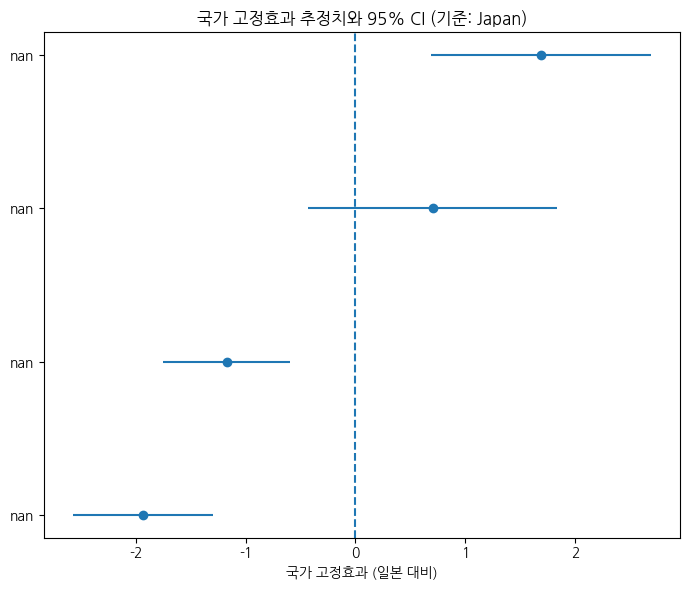

In [ ]:
# 국가 고정효과 계수와 신뢰구간
params = model_japan_ref.params
conf = model_japan_ref.conf_int()

nat_idx = [i for i in params.index if i.startswith("C(nation, Treatment(reference='Japan'))[T.")]
nat_df = pd.DataFrame({
    'coef': params[nat_idx],
    'ci_low': conf.loc[nat_idx, 0],
    'ci_high': conf.loc[nat_idx, 1]
})
# 보기 좋게 국가명만 추출
nat_df['nation'] = nat_df.index.str.extract(r"\[T\.(.*)\]")[0]
nat_df = nat_df.sort_values('coef')

fig = plt.figure(figsize=(7,6))
ypos = np.arange(len(nat_df))
plt.errorbar(nat_df['coef'], ypos, xerr=[nat_df['coef']-nat_df['ci_low'], nat_df['ci_high']-nat_df['coef']], fmt='o')
plt.axvline(0, linestyle='--')
plt.yticks(ypos, nat_df['nation'])
plt.xlabel('국가 고정효과 (일본 대비)')
plt.title("국가 고정효과 추정치와 95% CI (기준: Japan)")
plt.tight_layout()
# plt.savefig('fig_fe_by_country.png', dpi=200)
plt.show()


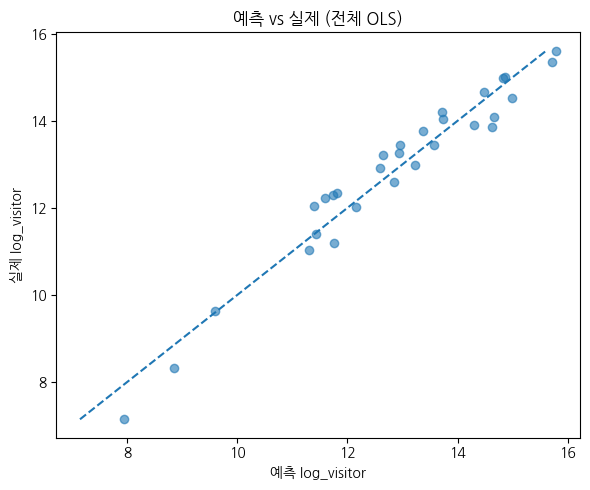

In [ ]:
fig = plt.figure(figsize=(6,5))
plt.scatter(model.fittedvalues, agg['log_visitor'], alpha=0.6)
mn, mx = agg['log_visitor'].min(), agg['log_visitor'].max()
plt.plot([mn, mx], [mn, mx], linestyle='--')  # y=x
plt.xlabel('예측 log_visitor')
plt.ylabel('실제 log_visitor')
plt.title('예측 vs 실제 (전체 OLS)')
plt.tight_layout()
# plt.savefig('fig_pred_vs_actual.png', dpi=200)
plt.show()


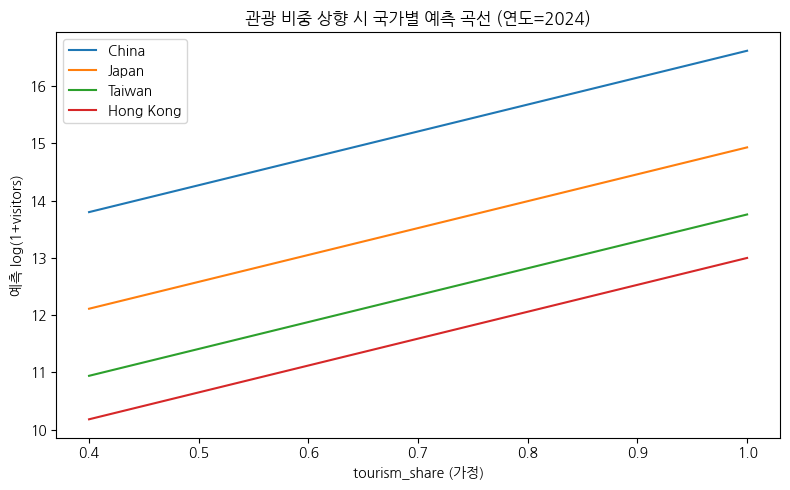

In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from statsmodels.formula.api import ols

# FE 포함 선형모형 (없으면 적합)
m_fe = ols("log_visitor ~ tourism_share + C(nation) + C(year)", data=agg).fit(cov_type="HC3")

grid = np.linspace(0.4, 1.0, 80)   # 가정: 실무에서 보는 현실 범위
year_fix = 2024
countries = ['China','Japan','Taiwan','Hong Kong']

plt.figure(figsize=(8,5))
for nat in countries:
    df_pred = pd.DataFrame({'tourism_share': grid,
                            'nation': nat,
                            'year': year_fix})
    yhat = m_fe.predict(df_pred)
    plt.plot(grid, yhat, label=f"{nat}")

plt.xlabel('tourism_share (가정)')
plt.ylabel('예측 log(1+visitors)')
plt.title('관광 비중 상향 시 국가별 예측 곡선 (연도=2024)')
plt.legend()
plt.tight_layout()
plt.show()


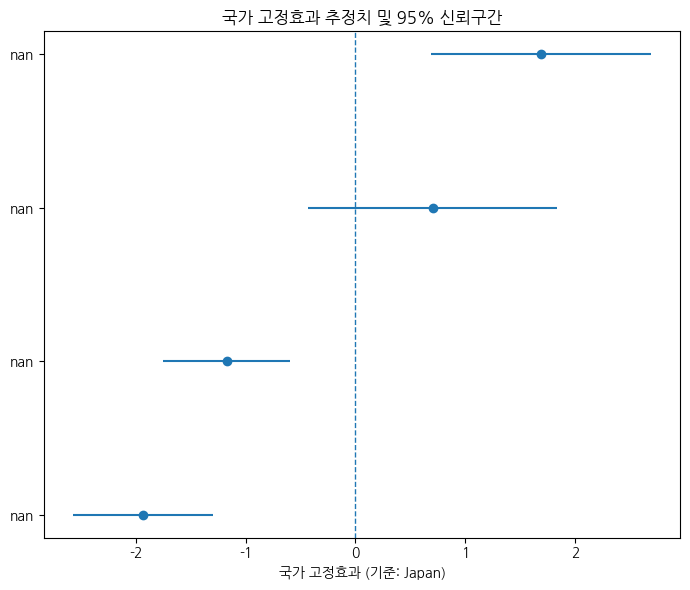

In [ ]:
# 일본 기준으로 적합한 모델을 이미 갖고 있다면 model_japan_ref 사용
mref = model_japan_ref  # 없으면: mref = ols("log_visitor ~ tourism_share + C(nation, Treatment(reference='Japan')) + C(year)", data=agg).fit(cov_type='HC3')

params = mref.params; conf = mref.conf_int()
idx = [i for i in params.index if i.startswith("C(nation, Treatment(reference='Japan'))[T.")]
nat_df = pd.DataFrame({
    'coef': params[idx],
    'ci_low': conf.loc[idx, 0],
    'ci_high': conf.loc[idx, 1],
})
nat_df['nation'] = nat_df.index.str.extract(r"\[T\.(.*)\]")[0]
nat_df = nat_df.sort_values('coef')

plt.figure(figsize=(7,6))
ypos = np.arange(len(nat_df))
plt.errorbar(nat_df['coef'], ypos,
             xerr=[nat_df['coef']-nat_df['ci_low'], nat_df['ci_high']-nat_df['coef']],
             fmt='o')
plt.axvline(0, ls='--', lw=1)
plt.yticks(ypos, nat_df['nation'])
plt.xlabel('국가 고정효과 (기준: Japan)')
plt.title('국가 고정효과 추정치 및 95% 신뢰구간')
plt.tight_layout()
plt.show()


### 관광 목적 비중이 높을 수록 젊은 방문객 수도 많아진다.

In [ ]:
import pandas as pd, numpy as np, re

PATH = "South_korea_visitor(19_24) - Total_19_24.csv"

# 1-1. 로드
df = None
for enc in ["utf-8-sig", "cp949", "utf-8"]:
    try:
        df = pd.read_csv(PATH, encoding=enc)
        break
    except Exception:
        pass
if df is None:
    raise RuntimeError("CSV 로드 실패")
df.columns = [c.strip() for c in df.columns]

# 1-2. 유연 매핑 함수
def find_col(cols, needles):
    m = {c.lower(): c for c in cols}
    for n in needles:
        if n.lower() in m: return m[n.lower()]
    for n in needles:
        for c in cols:
            if n.lower() in c.lower(): return c
    return None

c_date    = find_col(df.columns, ["date","연도","기간","year","month"])
c_nation  = find_col(df.columns, ["nation","국가","country"])
c_visitor = find_col(df.columns, ["visitor","visitors","방문","입국","인원","방문자"])
c_tourism = find_col(df.columns, ["tourism","관광","여행"])
c_business= find_col(df.columns, ["business","상용","비즈니스"])
c_official= find_col(df.columns, ["official affairs","official","공무"])
c_studying= find_col(df.columns, ["studying","study","유학","학업"])
c_others  = find_col(df.columns, ["others","기타"])

age0_20   = find_col(df.columns, ["age0-20","0-20","0~20","0_20","0-19","0~19","age0_19"])
age21_30  = find_col(df.columns, ["age21-30","21-30","21~30","21_30"])
age31_40  = find_col(df.columns, ["age31-40","31-40","31~40","31_40"])
age41_50  = find_col(df.columns, ["age41-50","41-50","41~50","41_50"])
age51_60  = find_col(df.columns, ["age51-60","51-60","51~60","51_60"])
age61p    = find_col(df.columns, ["age61","61+","61~","61"])

need = [c_date,c_nation,c_visitor,c_tourism,age21_30,age31_40]
if any(x is None for x in need):
    raise KeyError(f"필수 컬럼 누락: date/nation/visitor/tourism/age21-30/age31-40 중 확인")

# 1-3. 숫자 변환
def to_num(s):
    return (pd.Series(s).astype(str)
            .str.replace(",","",regex=False)
            .str.replace("%","",regex=False)
            .str.replace("\u00a0","",regex=False)
            .str.strip()
            .replace({"":np.nan,"-":np.nan})
           ).astype(float)

for c in [c_visitor,c_tourism,c_business,c_official,c_studying,c_others,
          age0_20,age21_30,age31_40,age41_50,age51_60,age61p]:
    if c and c in df.columns: df[c] = to_num(df[c])

# 1-4. year 추출 (연-월 or 연도)
def extract_year(x):
    s=str(x); m=re.search(r"(\d{4})", s)
    return int(m.group(1)) if m else np.nan
df["year"] = df[c_date].apply(extract_year).astype("Int64")

# 1-5. 목적 합계(있으면) 및 관광 비중
purpose_cols = [c for c in [c_tourism,c_business,c_official,c_studying,c_others] if c]
if purpose_cols:
    df["purpose_sum"] = df[purpose_cols].sum(axis=1)
    # 두 방식 중 하나 선택(데이터 일치 시 동일): 관광/총방문 또는 관광/목적합
    df["tourism_share"] = df[c_tourism] / df[c_visitor]  # 일관성 위해 이전과 동일
else:
    df["tourism_share"] = df[c_tourism] / df[c_visitor]

# 1-6. 젊은 방문객 수(21–40 = 21–30 + 31–40)
df["young_visitors"] = df[age21_30].fillna(0) + df[age31_40].fillna(0)

# 1-7. 로그 변환
df = df.dropna(subset=[c_nation,"year",c_visitor,"tourism_share","young_visitors"]).copy()
df["log_young"]   = np.log1p(df["young_visitors"])
df["log_visitor"] = np.log1p(df[c_visitor])  # (선택) 비교용

print(df[[c_nation,"year","tourism_share","young_visitors"]].head())


In [ ]:
# OLS 직전 데이터 사본
agg = df.copy()

# 핵심 컬럼들 숫자/문자 타입 정리
agg["tourism_share"] = pd.to_numeric(agg["tourism_share"], errors="coerce")
agg["young_visitors"] = pd.to_numeric(agg["young_visitors"], errors="coerce")
agg["log_young"] = np.log1p(agg["young_visitors"].astype("float64"))

# year: pandas nullable Int64 -> numpy int64 로 강제
# (결측이 있으면 먼저 드롭)
agg = agg.dropna(subset=["year", "tourism_share", "young_visitors"]).copy()
agg["year"] = agg["year"].astype("int64")          # ✅ numpy int64

# nation은 문자열로
agg["nation"] = agg[c_nation].astype(str)

# 확인
print(agg[["nation","year","tourism_share","young_visitors"]].dtypes)


In [ ]:
import statsmodels.formula.api as smf
import numpy as np
import pandas as pd

# 0) 핵심 열 강제 캐스팅 (숫자는 float64, nation은 str)
agg = df.copy()

agg["tourism_share"]  = pd.to_numeric(agg["tourism_share"], errors="coerce").astype("float64")
agg["young_visitors"] = pd.to_numeric(agg["young_visitors"], errors="coerce").astype("float64")
agg["log_young"]      = np.log1p(agg["young_visitors"]).astype("float64")
agg["nation"]         = agg["nation"].astype(str)

# year → 문자열(범주)로 바꿔 FE에 투입
agg = agg.dropna(subset=["year","tourism_share","young_visitors"]).copy()
agg["year"]      = agg["year"].astype("int64")      # 혹시 모를 잔여 Int64Dtype 제거
agg["year_str"]  = agg["year"].astype(str)          # ✅ 여기!

# 안전 확인
print(agg[["nation","year","year_str","tourism_share","young_visitors"]].dtypes)

# OLS (연도는 문자열로 FE)
formula = "log_young ~ tourism_share + C(nation) + C(year_str)"
ols = smf.ols(formula, data=agg).fit(cov_type="HC3")

print("\n=== OLS: 젊은 방문객 수 ~ 관광비중 (국가·연도 FE; year_str) ===")
print("coef(tourism_share) =", round(ols.params.get("tourism_share", np.nan), 4),
      "| p =", round(ols.pvalues.get("tourism_share", np.nan), 5),
      "| R² =", round(ols.rsquared, 3),
      "| n =", int(ols.nobs))
# print(ols.summary())


In [ ]:
import statsmodels.formula.api as smf

formula = "log_young ~ tourism_share + C(nation) + C(year)"
ols = smf.ols(formula, data=agg).fit(cov_type="HC3")

print("\n=== OLS: 젊은 방문객 수 ~ 관광비중 (국가·연도 FE) ===")
print("coef(tourism_share) =", round(ols.params.get("tourism_share", float("nan")), 4),
      "| p =", round(ols.pvalues.get("tourism_share", float("nan")), 5),
      "| R² =", round(ols.rsquared, 3),
      "| n =", int(ols.nobs))
# print(ols.summary())


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error

X = agg[["tourism_share","nation","year"]]
y = agg["log_young"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

pre = ColumnTransformer([
    ("num", StandardScaler(), ["tourism_share","year"]),
    ("cat", OneHotEncoder(drop="first"), ["nation"])
])

# 4-1. Ridge (선형)
ridge = Pipeline([("pre", pre), ("mdl", Ridge(alpha=10))])
ridge.fit(X_train, y_train)
pred_r = ridge.predict(X_test)
print(f"[Ridge] R²={r2_score(y_test, pred_r):.3f} | MAE={mean_absolute_error(y_test, pred_r):.3f}")

# 4-2. RandomForest (비선형)
rf = Pipeline([("pre", pre), ("mdl", RandomForestRegressor(
    n_estimators=400, max_depth=6, random_state=42
))])
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)
print(f"[RF] R²={r2_score(y_test, pred_rf):.3f} | MAE={mean_absolute_error(y_test, pred_rf):.3f}")

# 4-3. 중요도
rf_m = rf.named_steps["mdl"]
fn = rf.named_steps["pre"].get_feature_names_out()
importances = pd.Series(rf_m.feature_importances_, index=fn).sort_values(ascending=False)
print("\n[Feature Importance]\n", importances)


In [ ]:
import statsmodels.formula.api as smf

# 기준(reference)을 명시 (예: 일본 기준)
formula = "log_young ~ tourism_share + C(nation, Treatment(reference='Japan')) + C(year_str, Treatment(reference='2019'))"
ols_noFE = smf.ols(formula, data=agg).fit(cov_type="HC3")

print("=== OLS (고정효과 통제 X, 각 효과 추정) ===")
print(f"coef(tourism_share) = {ols_noFE.params['tourism_share']:.4f} | p = {ols_noFE.pvalues['tourism_share']:.4f}")
print(f"R² = {ols_noFE.rsquared:.3f} | n = {int(ols_noFE.nobs)}")

# 국가별 효과만 필터링
country_effects = ols_noFE.params.filter(like="C(nation)").round(4)
year_effects = ols_noFE.params.filter(like="C(year_str)").round(4)

print("\n--- 국가별 효과 (기준: Japan) ---")
print(country_effects)

print("\n--- 연도별 효과 (기준: 2019) ---")
print(year_effects)


In [ ]:
# =========================================
# 0) 준비
# =========================================
import pandas as pd, numpy as np, re
import statsmodels.formula.api as smf

PATH = "South_korea_visitor(19_24) - Total_19_24.csv"

# =========================================
# 1) 데이터 로드
# =========================================
df = None
for enc in ["utf-8-sig", "cp949", "utf-8"]:
    try:
        df = pd.read_csv(PATH, encoding=enc)
        break
    except Exception:
        pass
if df is None:
    raise RuntimeError("CSV 로드 실패: 경로/파일명/인코딩 확인")

df.columns = [c.strip() for c in df.columns]

# =========================================
# 2) 컬럼 매핑 (유연 탐색)
# =========================================
def find_col(cols, needles):
    m = {c.lower(): c for c in cols}
    for n in needles:
        if n.lower() in m: return m[n.lower()]
    for n in needles:
        for c in cols:
            if n.lower() in c.lower(): return c
    return None

c_date    = find_col(df.columns, ["date","연도","기간","year","month"])
c_nation  = find_col(df.columns, ["nation","국가","country"])
c_visitor = find_col(df.columns, ["visitor","visitors","방문","입국","인원","방문자"])
c_tourism = find_col(df.columns, ["tourism","관광","여행"])
age0_20   = find_col(df.columns, ["age0-20","0-20","0~20","0_20","0-19","0~19","age0_19"])
age21_30  = find_col(df.columns, ["age21-30","21-30","21~30","21_30"])
age31_40  = find_col(df.columns, ["age31-40","31-40","31~40","31_40"])

need = [c_date,c_nation,c_visitor,c_tourism,age0_20,age21_30,age31_40]
if any(x is None for x in need):
    raise KeyError(f"필수 컬럼 누락: {dict(date=c_date, nation=c_nation, visitor=c_visitor, tourism=c_tourism, a0_20=age0_20, a21_30=age21_30, a31_40=age31_40)}")

# =========================================
# 3) 숫자형 변환 + year / 파생변수
# =========================================
def to_num(s):
    return (pd.Series(s).astype(str)
            .str.replace(",","",regex=False)
            .str.replace("%","",regex=False)
            .str.replace("\u00a0","",regex=False)
            .str.strip()
            .replace({"":np.nan,"-":np.nan})
           ).astype(float)

for c in [c_visitor, c_tourism, age0_20, age21_30, age31_40]:
    df[c] = to_num(df[c])

def extract_year(x):
    s = str(x)
    m = re.search(r"(\d{4})", s)
    return int(m.group(1)) if m else np.nan

df["year"] = df[c_date].apply(extract_year).astype("Int64")
df["nation"] = df[c_nation].astype(str)

# 관광 비중, 젊은 방문객, 로그
df["tourism_share"]  = df[c_tourism] / df[c_visitor]
df["young_visitors"] = df[age0_20].fillna(0) + df[age21_30].fillna(0) + df[age31_40].fillna(0)
df = df.dropna(subset=["nation","year","tourism_share","young_visitors"]).copy()

# year_str (연도 FE를 범주로 보기 위함)
df["year"] = df["year"].astype("int64")
df["year_str"] = df["year"].astype(str)

# =========================================
# 4) 기준값(일본, 2019) 존재 확인 → 없으면 자동 대체
# =========================================
has_japan = (df["nation"] == "Japan").any()
if not has_japan:
    # 가장 빈도가 높은 국가를 기준으로 자동 교체
    top_nation = df["nation"].value_counts().idxmax()
    print(f"[알림] Japan이 없어서 기준국가를 '{top_nation}'로 대체합니다.")
    nation_ref = top_nation
else:
    nation_ref = "Japan"

has_2019 = (df["year_str"] == "2019").any()
if not has_2019:
    top_year = df["year_str"].value_counts().idxmax()
    print(f"[알림] 2019가 없어서 기준연도를 '{top_year}'로 대체합니다.")
    year_ref = top_year
else:
    year_ref = "2019"

# =========================================
# 5) OLS (고정효과 통제 X, 각 효과 추정)
#    - tourism_share + 국가더미 + 연도더미를 모두 '효과'로 추정
#    - 기준: nation_ref / year_ref
# =========================================
agg = df.copy()
agg["log_young"] = np.log1p(agg["young_visitors"]).astype("float64")

formula = f"log_young ~ tourism_share + C(nation, Treatment(reference='{nation_ref}')) + C(year_str, Treatment(reference='{year_ref}'))"
ols_noFE = smf.ols(formula, data=agg).fit(cov_type="HC3")

print("\n=== OLS (고정효과 통제 X, 각 효과 추정) ===")
print(f"coef(tourism_share) = {ols_noFE.params['tourism_share']:.4f} | p = {ols_noFE.pvalues['tourism_share']:.4f}")
print(f"R² = {ols_noFE.rsquared:.3f} | n = {int(ols_noFE.nobs)}")

# =========================================
# 6) 국가/연도 효과 테이블 추출 + 배율(e^β) 변환
#    (계수 이름이 'C(nation, Treatment(reference=...))[...]' 형태이므로 정규식으로 안전 필터)
# =========================================
idx = pd.Index(ols_noFE.params.index)

mask_nat  = idx.str.contains(r"^C\(nation.*\)\[T\.", regex=True)
mask_year = idx.str.contains(r"^C\(year_str.*\)\[T\.", regex=True)

country_params = ols_noFE.params[mask_nat].copy()
year_params    = ols_noFE.params[mask_year].copy()

def effect_table(params, pvals):
    out = pd.DataFrame({
        "coef": params,
        "p": pvals[params.index]
    })
    out["multiplier(e^coef)"] = np.exp(out["coef"])
    return out.sort_index()

country_table = effect_table(country_params, ols_noFE.pvalues)
year_table    = effect_table(year_params,    ols_noFE.pvalues)

print("\n--- 국가별 효과 (기준:", nation_ref, ") ---")
print(country_table.round(4))

print("\n--- 연도별 효과 (기준:", year_ref, ") ---")
print(year_table.round(4))

# (선택) 전체 파라미터 이름을 보고 싶으면 아래 주석 해제
# print("\n[디버그] params index:\n", list(ols_noFE.params.index))


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --------------------------------
# 0) CSV 로드 (인코딩 자동 감지)
# --------------------------------
path = "외래관광객조사 DATA_2024.csv"
df = None
for enc in ["utf-8-sig","cp949","utf-8"]:
    try:
        df = pd.read_csv(path, encoding=enc, low_memory=False)
        break
    except Exception:
        pass
assert df is not None, "CSV 로드 실패"

# --------------------------------
# 1) 국가 및 가중치 표준화
# --------------------------------
# nation 컬럼 자동 탐색 → 표준화
nation_col = next((c for c in ["nation","D_COU1","D_NAT","국가","국가코드"] if c in df.columns), None)
assert nation_col is not None, "국가 코드 컬럼을 찾지 못했습니다."
df = df.rename(columns={nation_col:"nation"})

# 가중치 컬럼 표준화
w_col = next((c for c in ["weight_total","WT","Weight","WEIGHT","가중값"] if c in df.columns), None)
if w_col is None:
    df["weight_total"] = 1.0
else:
    df["weight_total"] = pd.to_numeric(df[w_col], errors="coerce").fillna(0)

# 분석 대상 국가 4개
nation_map = {1:"일본", 2:"중국", 3:"홍콩", 5:"대만"}
df_4 = df[df["nation"].isin(nation_map.keys())].copy()
df_4["nation_name"] = df_4["nation"].map(nation_map)

# --------------------------------
# 2) Q4_1a1 ~ Q4_1a3 (주요 이용 사이트)
# --------------------------------
site_cols = [c for c in ["Q4_1a1","Q4_1a2","Q4_1a3"] if c in df_4.columns]
assert site_cols, "Q4_1a1~Q4_1a3 컬럼이 존재하지 않습니다."

# 코드별 라벨
code_label = {
    1:"1. 글로벌 포털(구글 등)",
    2:"2. 한국 포털(네이버·다음 등)",
    3:"3. 자국 포털(Yahoo Japan·Baidu 등)",
    4:"4. 여행전문/앱(트립어드바이저·Hotels.com 등)",
    5:"5. 소셜미디어(페북·인스타·X·웨이보 등)",
    6:"6. 동영상 사이트(유튜브 등)",
    7:"7. 여행 관련 블로그",
    8:"8. 여행사 홈페이지",
    9:"9. 개별 관광지 홈페이지",
    10:"10. 항공사/호텔 홈페이지",
    11:"11. 한국 공공기관(VisitKorea/대사관/무역관 등)",
    12:"12. 기타",
}
code_order = list(code_label.keys())

# --------------------------------
# 3) 선택 수 기준 가중 비율 계산
# --------------------------------
def site_dist_by_selection(d: pd.DataFrame) -> pd.DataFrame:
    m = d[["nation_name","weight_total"] + site_cols].melt(
        id_vars=["nation_name","weight_total"],
        value_vars=site_cols,
        var_name="slot",
        value_name="code"
    ).dropna(subset=["code"])
    m["code"] = pd.to_numeric(m["code"], errors="coerce")

    grp = m.groupby(["nation_name","code"])["weight_total"].sum()
    grp = grp.groupby(level=0).apply(lambda s: 100 * s / s.sum())
    grp = grp.rename("pct").reset_index()  # nation_name 중복 방지

    # 빠진 코드 0으로 채우기
    idx = pd.MultiIndex.from_product(
        [grp["nation_name"].unique(), code_order],
        names=["nation_name","code"]
    )
    grp = grp.set_index(["nation_name","code"]).reindex(idx).fillna({"pct":0}).reset_index()
    grp["label"] = grp["code"].map(code_label)
    return grp

dist = site_dist_by_selection(df_4)

# 보기 쉬운 표
table = dist.pivot(index="label", columns="nation_name", values="pct").reindex(code_label.values())
print("▶︎ 국가별 주요 이용 사이트(1~12) 선택 비율(%)")
print(table.round(1))

# --------------------------------
# 4) 시각화 (국가별 12항목 막대 그래프)
# --------------------------------
for name in ["중국","대만","일본","홍콩"]:
    sub = dist[dist["nation_name"] == name].sort_values("code")
    fig, ax = plt.subplots(figsize=(11,4))
    bars = ax.bar(sub["label"], sub["pct"], color="steelblue", alpha=0.85)
    ax.set_title(f"{name}: 주요 이용 사이트(1~12) 분포(%)", fontsize=13)
    ax.set_ylabel("비율(%)", fontsize=11)
    ax.set_ylim(0, max(30, sub["pct"].max()*1.25))
    ax.tick_params(axis="x", rotation=25, labelsize=9)
    ax.bar_label(bars, labels=[f"{v:.1f}%" for v in sub["pct"]], padding=3, fontsize=9)
    plt.tight_layout()
    plt.show()


In [ ]:
def site_dist_by_selection(d: pd.DataFrame) -> pd.DataFrame:
    """
    Q4_1a1~Q4_1a3의 '선택 건수(슬롯)' 기준 가중 비율(%).
    reset_index 충돌이 없도록, 합계→전체합으로 나누는 방식으로 계산.
    """
    # 세 칸을 세로로 풀기
    m = d[["nation_name","weight_total"] + site_cols].melt(
        id_vars=["nation_name","weight_total"],
        value_vars=site_cols,
        var_name="slot",
        value_name="code"
    ).dropna(subset=["code"])
    m["code"] = pd.to_numeric(m["code"], errors="coerce")

    # 1) 국가×코드별 가중합
    by = (m.groupby(["nation_name","code"], as_index=False)["weight_total"]
            .sum()
            .rename(columns={"weight_total":"w"}))

    # 2) 국가별 전체 선택 가중합
    tot = (by.groupby("nation_name", as_index=False)["w"]
             .sum()
             .rename(columns={"w":"wtot"}))

    # 3) 퍼센트 계산
    grp = by.merge(tot, on="nation_name")
    grp["pct"] = 100 * grp["w"] / grp["wtot"]
    grp = grp[["nation_name","code","pct"]]

    # 4) 빠진 코드(1~12) 0으로 채우기
    idx = pd.MultiIndex.from_product(
        [grp["nation_name"].unique(), list(code_label.keys())],
        names=["nation_name","code"]
    )
    grp = (grp.set_index(["nation_name","code"])
               .reindex(idx)
               .fillna({"pct":0})
               .reset_index())

    grp["label"] = grp["code"].map(code_label)
    return grp


In [ ]:
# 계산
dist = site_dist_by_selection(df_4)

# 표 (국가×항목)
table = dist.pivot(index="label", columns="nation_name", values="pct") \
            .reindex(code_label.values())
print(table.round(1))

# 시각화 (국가별 12항목)
for name in ["중국","대만","일본","홍콩"]:
    sub = dist[dist["nation_name"]==name].sort_values("code")
    fig, ax = plt.subplots(figsize=(11,4))
    bars = ax.bar(sub["label"], sub["pct"])
    ax.set_title(f"{name}: 주요 이용 사이트(1~12) 분포(%)", fontsize=13)
    ax.set_ylabel("비율(%)")
    ax.set_ylim(0, max(30, sub["pct"].max()*1.25))
    ax.tick_params(axis="x", rotation=25)
    ax.bar_label(bars, labels=[f"{v:.1f}%" for v in sub["pct"]], padding=3, fontsize=9)
    plt.tight_layout()
    plt.show()


In [ ]:
import pandas as pd

# 1) 데이터 로드
path = "/mnt/data/외래관광객조사 DATA_2024.csv"
df = None
for enc in ["utf-8-sig", "cp949", "utf-8"]:
    try:
        df = pd.read_csv(path, encoding=enc)
        break
    except Exception:
        pass
assert df is not None, "CSV 로드 실패"

# 2) 국가 코드 매핑 (이미지 기준)
nat_map = {1: "중국", 2: "일본", 3: "대만", 5: "홍콩"}

# 3) 분석 설정
purpose_col = "Q1"     # 방한 주요 목적 (1=여가/위락/휴식=관광)
nation_col  = "D_NAT"  # 국가 코드
target_countries = [1, 2, 3, 5]

# 4) 4개국만 필터
df_4 = df[df[nation_col].isin(target_countries)].copy()

# 5) (가중치 미적용) 관광 목적 비율 계산
#    비율 = (Q1==1)인 응답 비중
tourism_ratio = (
    df_4.groupby(nation_col)[purpose_col]
        .apply(lambda s: (s == 1).mean() * 100)
        .rename("tourism_pct")
        .reset_index()
)
tourism_ratio["nation"] = tourism_ratio[nation_col].map(nat_map)
tourism_ratio = tourism_ratio[["nation", "tourism_pct"]]
print(tourism_ratio)

# ---------- (선택) 가중치 적용 버전 ----------
# 만약 표본가중치 'weight'를 적용해 비율을 구하고 싶다면 아래 주석 해제
# def weighted_pct(group):
#     w = group["weight"].fillna(0)
#     hit = (group[purpose_col] == 1).astype(int)
#     return ( (w * hit).sum() / w.sum() ) * 100 if w.sum() > 0 else float("nan")
#
# tourism_ratio_w = (
#     df_4.groupby(nation_col).apply(weighted_pct).rename("tourism_pct_w").reset_index()
# )
# tourism_ratio_w["nation"] = tourism_ratio_w[nation_col].map(nat_map)
# tourism_ratio_w = tourism_ratio_w[["nation", "tourism_pct_w"]]
# print(tourism_ratio_w)


In [ ]:
import pandas as pd

# 1) 데이터 로드
path = "외래관광객조사 DATA_2024.csv"
df = None
for enc in ["utf-8-sig", "cp949", "utf-8"]:
    try:
        df = pd.read_csv(path, encoding=enc)
        break
    except Exception:
        pass
assert df is not None, "CSV 로드 실패"

# 2) 대상 국가 매핑 및 필터
nat_map = {1: "중국", 2: "일본", 3: "대만", 5: "홍콩"}
df_sub = df[df["D_NAT"].isin([1, 2, 3, 5])].copy()
df_sub["nation"] = df_sub["D_NAT"].map(nat_map)

# 3) 연령 구간 매핑 (요청한 4구간)
# D_AGE 코드표: 1=15–19, 2=20대, 3=30대, 4=40대, 5=50대, 6=60대+
def map_age_group(x):
    if x == 1:          return "15-19세"
    if x in [2, 3]:     return "20·30대"
    if x in [4, 5]:     return "40·50대"
    if x == 6:          return "60대 이상"
    return None

df_sub["age_group"] = df_sub["D_AGE"].apply(map_age_group)

# 보기 좋은 컬럼 순서 보장
order = ["15-19세", "20·30대", "40·50대", "60대 이상"]
df_sub["age_group"] = pd.Categorical(df_sub["age_group"], categories=order, ordered=True)

# 4) (무가중치) 국가별 연령 비중
age_share = (pd.crosstab(df_sub["nation"], df_sub["age_group"], normalize="index") * 100).round(2)
age_share = age_share.reindex(columns=order)  # 열 순서 고정
print("[무가중치] 국가별 연령 비중(%)")
print(age_share)

# 5) (가중치 적용) 국가별 연령 비중
#   - 표본가중치가 'weight' 컬럼에 있다고 가정 (필요 시 'weight1' 등으로 교체)
if "weight" in df_sub.columns:
    tbl_w = df_sub.pivot_table(index="nation",
                               columns="age_group",
                               values="weight",
                               aggfunc="sum").reindex(columns=order).fillna(0)
    age_share_w = (tbl_w.div(tbl_w.sum(axis=1), axis=0) * 100).round(2)
    print("\n[가중치 적용] 국가별 연령 비중(%)")
    print(age_share_w)
else:
    print("\n[알림] 가중치 컬럼('weight')이 없어 무가중치 결과만 출력했습니다.")


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ===== 기본 설정 =====
age_cols = ['age0-20','age21-30','age31-40','age41-50','age51-60','age61']

def to_num(s):
    return (pd.Series(s)
            .astype(str)
            .str.replace(',', '', regex=False)
            .str.replace('%', '', regex=False)
            .str.replace('\u00a0', '', regex=False)
            .str.strip()
            .replace({'': np.nan, '-': np.nan})
            .astype(float))

# ===== 데이터 전처리 =====
df['visitor']  = to_num(df['visitor'])
df['tourism']  = to_num(df['tourism'])
for c in age_cols:
    df[c] = to_num(df[c])

df = df.dropna(subset=['nation', 'visitor', 'tourism'])
df = df[(df['visitor'] > 0) & (df['tourism'] >= 0) & (df['tourism'] <= df['visitor'])].copy()
df = df[df['nation'].str.strip().str.lower() != 'usa']

ratio = (df['tourism'] / df['visitor']).clip(0, 1)

age_df = df[age_cols].copy()
is_ratio_by_col = (age_df.max(skipna=True) <= 1.5)
is_percent_by_col = (age_df.max(skipna=True).between(1.5, 100.0))

age_counts = pd.DataFrame(index=df.index)
for c in age_cols:
    col = age_df[c]
    if is_ratio_by_col[c]:
        age_counts[c] = col.fillna(0) * df['tourism']
    elif is_percent_by_col[c]:
        age_counts[c] = (col.fillna(0) / 100.0) * df['tourism']
    else:
        age_counts[c] = col.fillna(0) * ratio

# ===== 연도별 국가 합산 =====
age_by_nat_year = age_counts.join(df[['nation','year']]).groupby(['nation','year'])[age_cols].sum(min_count=1)
age_share_nat_year = age_by_nat_year.div(age_by_nat_year.sum(axis=1), axis=0).reset_index()

# ===== 2019 vs 2024 비교 시각화 =====
sns.set_style("whitegrid")
colors = sns.color_palette("Blues", n_colors=len(age_cols)+2)[2:]

fig, axes = plt.subplots(1, 2, figsize=(14,6), sharey=True)
years_to_show = [2019, 2024]

for i, yr in enumerate(years_to_show):
    data = age_share_nat_year[age_share_nat_year['year'] == yr]
    if data.empty:
        axes[i].text(0.5, 0.5, f"{yr} 데이터 없음", ha='center', va='center')
        continue

    bottom = np.zeros(len(data))
    for j, c in enumerate(age_cols):
        axes[i].bar(data['nation'], data[c], bottom=bottom, color=colors[j], label=c)
        # 비율 텍스트 표시
        for k, val in enumerate(data[c]):
            if val > 0.03:
                y_pos = bottom[k] + val / 2
                axes[i].text(k, y_pos, f"{val*100:.0f}%", ha='center', va='center', fontsize=8, color='white')
        bottom += data[c].to_numpy()

    axes[i].set_title(f"{yr}년 관광 목적 방문객 연령대 구성비 (미국 제외)")
    axes[i].set_xticklabels(data['nation'], rotation=45, ha='right')
    axes[i].set_ylim(0, 1)
    axes[i].set_ylabel('비율 (100%)' if i == 0 else "")

# ===== 범례, 마무리 =====
fig.legend(title='연령대', bbox_to_anchor=(1.04, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 파스텔 블루 계열 팔레트 선택
colors = sns.color_palette("Blues", n_colors=len(age_cols)+2)[2:]  # 너무 연한 부분 제외

plt.figure(figsize=(10,6))
bottom = np.zeros(len(age_share_by_nat))
for i, c in enumerate(age_cols):
    plt.bar(age_share_by_nat.index, age_share_by_nat[c], bottom=bottom, label=c, color=colors[i])
    bottom += age_share_by_nat[c].to_numpy()

plt.title('국가별 관광 목적 방문객 연령대 구성비 (2019–2024 합산)', fontsize=13)
plt.ylabel('비율 (100%)')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.legend(title='연령대', bbox_to_anchor=(1.02,1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
nation_map = {1:"일본", 2:"중국", 3:"홍콩", 5:"대만"}

def rate_by_country(flag_col, base="all"):
    out = []
    for code, name in nation_map.items():
        d = df_4[df_4["nation"]==code]
        if base=="all":
            den = d["weight_total"].sum()
            num = (d[flag_col]*d["weight_total"]).sum()
        else:  # base == "info"
            d2 = d[d["got_info_any"]==1]
            den = d2["weight_total"].sum()
            num = (d2[flag_col]*d2["weight_total"]).sum()
        rate = num/den if den>0 else np.nan
        mz  = (d["MZ_i"]*d["weight_total"]).sum() / d["weight_total"].sum()
        out.append({"nation":name,"MZ_share":mz,"rate":rate})
    return pd.DataFrame(out)

tab_all  = rate_by_country("DIGITAL_i", base="all")   # 전체 대비
tab_info = rate_by_country("DIGITAL_i", base="info")  # 정보탐색자 대비

print("== 전체 대비 ==")
print(tab_all)
print("\n== 정보탐색자 대비 ==")
print(tab_info)


In [ ]:
import pandas as pd

# 1️⃣ CSV 다시 로드 (파일 경로 확인)
path = "외래관광객조사 DATA_2024.csv"
df = None
for enc in ["utf-8-sig", "cp949", "utf-8"]:
    try:
        df = pd.read_csv(path, encoding=enc)
        break
    except Exception as e:
        print("Encoding error:", e)
assert df is not None, "CSV 로드 실패"

# 2️⃣ 주요 컬럼명 필터링
cols = [c for c in df.columns if c.lower().startswith("q4")]
print("🔹 Q4 계열 전체 컬럼:", cols)

# 3️⃣ Q4 관련 칼럼의 데이터 샘플
pd.set_option('display.max_columns', None)
print("\n🔹 Q4 관련 칼럼 상위 10행 샘플:")
print(df[cols].head(10))


In [ ]:
import pandas as pd
import numpy as np

# Q4_1a1~Q4_1a3 중 하나라도 5(SNS) 또는 6(유튜브)이면 DIGITAL=1
sns_codes = [5, 6]
site_cols = ["Q4_1a1", "Q4_1a2", "Q4_1a3"]

df_4["DIGITAL_i"] = df_4[site_cols].apply(
    lambda row: any(x in sns_codes for x in row.values if pd.notna(x)), axis=1
).astype(int)

print("✅ DIGITAL_i 값 분포:\n", df_4["DIGITAL_i"].value_counts(dropna=False))


In [ ]:
nation_map = {1: "일본", 2: "중국", 3: "홍콩", 5: "대만"}

def rate_by_country(flag_col, base="all"):
    out = []
    for code, name in nation_map.items():
        d = df_4[df_4["nation"] == code]
        if base == "all":
            den = d["weight_total"].sum()
            num = (d[flag_col] * d["weight_total"]).sum()
        else:  # base == "info"
            d2 = d[(d["Q4a1"].notna()) | (d["Q4a2"].notna()) | (d["Q4a3"].notna())]
            den = d2["weight_total"].sum()
            num = (d2[flag_col] * d2["weight_total"]).sum()
        rate = num / den if den > 0 else np.nan
        mz_share = (d["MZ_i"] * d["weight_total"]).sum() / d["weight_total"].sum()
        out.append({"nation": name, "MZ_share": mz_share, "rate": rate})
    return pd.DataFrame(out)

tab_all  = rate_by_country("DIGITAL_i", base="all")
tab_info = rate_by_country("DIGITAL_i", base="info")

print("=== 전체 기준 ===")
print(tab_all)
print("\n=== 정보탐색자 기준 ===")
print(tab_info)


In [ ]:
import statsmodels.api as sm

X = sm.add_constant(tab_info["MZ_share"])
y = tab_info["rate"]
model = sm.OLS(y, X).fit()
print(model.summary())


In [ ]:
import statsmodels.api as sm

nation_map = {1:"일본", 2:"중국", 3:"홍콩", 5:"대만"}
results = []

for code, name in nation_map.items():
    d = df_4[df_4["nation"] == code].copy()
    if len(d) < 30:
        continue  # 표본 너무 적으면 스킵

    X = sm.add_constant(d["MZ_i"])
    y = d["DIGITAL_i"]
    model = sm.OLS(y, X, weights=d["weight_total"]).fit()

    results.append({
        "nation": name,
        "coef_MZ": model.params["MZ_i"],
        "pval": model.pvalues["MZ_i"],
        "R2": model.rsquared
    })

result_df = pd.DataFrame(results)
print(result_df)
